# The finite volume method for unsteady flow

The conservation law for the transport of a scalar in an unsteady flow has the general form

$$
\frac{\partial}{\partial {t}} (\rho \phi) + div (\rho \textbf{u} \phi) 
= div (\Gamma\ grad \ \phi) + S_{\phi}
$$

## 2D unsteady state heat conduction
$$
\rho c \frac{\partial{T}}{\partial{t}} =
 \frac{\partial}{\partial{x}} (\kappa\frac{\partial{T}}{\partial{x}}) + 
 \frac{\partial}{\partial{y}} (\kappa\frac{\partial{T}}{\partial{y}})
  + S
$$

* Discretisation

                  ╶───╶───╶───╶───╶───
            . . . │ ● │ ● │ ● │ ● │ ● │ . . . 
                  ╶───╶───╶───╶───╶───
                              ...

                              N
                        ╶───╶───╶───
                  . . . │ W │ P │ E │ . . .
                        ╶───╶───╶───
                              S

                              ...
                  ╶───╶───╶───╶───╶───
            . . . │ ● │ ● │ ● │ ● │ ● │. . . 
                  ╶───╶───╶───╶───╶───



* The resulting equations for the explicit scheme is

$$
a_P^oT_P = a_E^oT_E^o + a_W^oT_W^o + a_N^oT_N^o + a_S^oT_S^o + a_PT_P^o + S_u 
$$

$$a_P^0 = \rho c \frac{\Delta V}{\Delta t}$$ 

$$a_E^o = a_W^o = \kappa \frac{\Delta y}{\Delta x}$$

$$a_N^o = a_S^o = \kappa \frac{\Delta x}{\Delta y}$$

$$a_P = {a_P^o - (a_W^o + a_E^o + a_S^o + a_N^o - S_p)}$$


**Example** 

A copper plate is initially at a uniform temperature of 100°C. At a certain time
t = 0 the temperature of the east, north and south sides of the plate are suddenly reduced to 0°C. 
The west surface is kept at 100°C. Use the explicit finite volume methods to calculate the transient 
temperature distribution of the slab at time t = 10 s. 
The data are: plate width W = 200 cm, Plate height H = 200 cm, thermal conductivity k = 385 W/m.K and rho = 8850 kg/m3 and c = 389 J/kg/k. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from boundary_condition import BoundaryCondition
from heat_diffusion_solver import HeatDiffusionSolver
from rectangular_plate import RectangularPlate


dt = 0.03
time_interval = 10

plate1 = RectangularPlate(0.2, 0.2, 8850, 389, 385)
plate1.discretise(50, 50)
plate1.temperature = 100  # initial temperature

plate2 = plate1.copy()
plate3 = plate1.copy()



def calculate():
    solver = HeatDiffusionSolver(dt, time_interval)
    solver.set_boundary_condition(
        east_bc=BoundaryCondition('Dirichlet', lambda x: 100),
        west_bc=BoundaryCondition('Dirichlet', lambda x: 0),
        north_bc=BoundaryCondition('Dirichlet', lambda x: 0),
        south_bc=BoundaryCondition('Dirichlet', lambda x: 0)
    )

    # Solve for plate1
    solver.plate = plate1
    solver.solve()
    plate1_time_temp_dist = solver.time_temp_dist.copy()

    # Solve for plate2 with different boundary conditions
    solver.west_bc = BoundaryCondition('Dirichlet', lambda x: 100)
    solver.east_bc = BoundaryCondition('Dirichlet', lambda x: 0)
    solver.plate = plate2
    solver.solve()
    plate2_time_temp_dist = solver.time_temp_dist.copy()

    # Superposition of the solutions of plate1 and plate 2. Note: Temperature is not additive
    superposition_sol = np.maximum(
        plate1_time_temp_dist, plate2_time_temp_dist)

    # Solve for plate3 with the boundary conditions of plate1 and plate2 combined
    solver.west_bc = BoundaryCondition('Dirichlet', lambda x: 100)
    solver.east_bc = BoundaryCondition('Dirichlet', lambda x: 100)

    solver.plate = plate3
    solver.solve()
    plate3_time_temp_dist = solver.time_temp_dist.copy()

    return plate1_time_temp_dist, plate2_time_temp_dist, plate3_time_temp_dist, superposition_sol


def plot_temperature_evolution(time_temp_dists, nt_steps, save_animation=False):
    # Common options for colormesh plots
    colormesh_options = {
        'cmap': plt.cm.jet,
        'vmin': 0,
        'vmax': 100
    }

    title_options = {
        'color': '#fff',
        'fontsize': 9
    }

    def update(n):
        # Set the figure title based on the current time
        title.set_text(f'Temperature at t = {n*dt:.2f} s')

        # Update the colormesh plots in each subplot
        mesh1 = ax1.pcolormesh(time_temp_dists[0][n], **colormesh_options)
        mesh2 = ax2.pcolormesh(time_temp_dists[1][n], **colormesh_options)
        mesh3 = ax3.pcolormesh(time_temp_dists[2][n], **colormesh_options)
        mesh4 = ax4.pcolormesh(time_temp_dists[3][n], **colormesh_options)

        return mesh1, mesh2, mesh3, mesh4, title

    # Create a figure with a grid of subplots
    fig = plt.figure(constrained_layout=True, facecolor='#111')
    spec = fig.add_gridspec(2, 2)

    # Add subplots to the figure with descriptive titles
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_title('Right Source Only', **title_options)

    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_title('Left Source Only', **title_options)

    ax3 = fig.add_subplot(spec[1, 0])
    ax3.set_title('Right & Left Sources', **title_options)

    ax4 = fig.add_subplot(spec[1, 1])
    ax4.set_title('Superposition of Right and Left Sources', **title_options)

    # Remove ticks from all subplots
    for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a title for the entire figure
    title = fig.suptitle('Temperature at t = 0.00 s',
                         fontsize=11, color='#fff')

    # Create a colorbar for all subplots
    cbar = fig.colorbar(ax1.pcolormesh(time_temp_dists[0][0], **colormesh_options), ax=fig.axes,
                        orientation='vertical')
    cbar_ticks_label = cbar.ax.get_yticklabels()
    cbar.set_label('Temperature', loc='center', **title_options)

    # Set color of colorbar tick labels
    for label in cbar_ticks_label:
        label.set_color('#fff')

    if save_animation:
        anim = FuncAnimation(fig, update, frames=nt_steps, repeat=False)
        anim.save("heat_equation_solution.mp4")
    else:
        # If not animating, update the plot for the final time step and display
        update(time_temp_dists[0].shape[0] - 1)
        plt.show()



Started Calculation
Finished Calculation
Started Plot


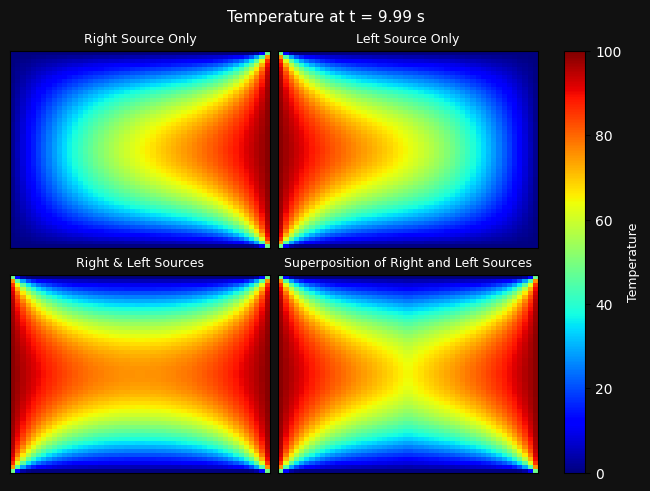

Finished Plot


In [3]:
print('Started Calculation')
p1, p2, p3, s = calculate()
print('Finished Calculation')

print('Started Plot')
plot_temperature_evolution([p1, p2, p3, s], p1.shape[0])
print('Finished Plot')